# Deep Learning IndabaX Rwanda CNN tutorial

* In this tutorial 
we will show how to design and train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions
* the ConvNet overview slides can be found on the tutorial [Github repository](https://github.com/mustafaghali/IndabaX-Rwanda-CNN-tutorial/blob/master/ConvNets%20presentation.pptx)

### When we use the CNNs we make use of the following assumptions about the input images signals 

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [42]:
from plot_lib import plot_data, plot_model, set_default # A simple custom wrapper on top of matplotlib 

In [43]:
set_default() #reset the wrapper parameters

In [44]:
#import libraraies needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [45]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Fashion-MNIST Dataset (MNIST)
<img src="Resources/fashion-mnist-sprite.png" height="100">

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [46]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.FashionMNIST('../data/Fashion-MNIST', transform=img_transform,download=True)
test_dataset = datasets.FashionMNIST('../data/Fashion-MNIST', transform=img_transform,download=True, train= False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

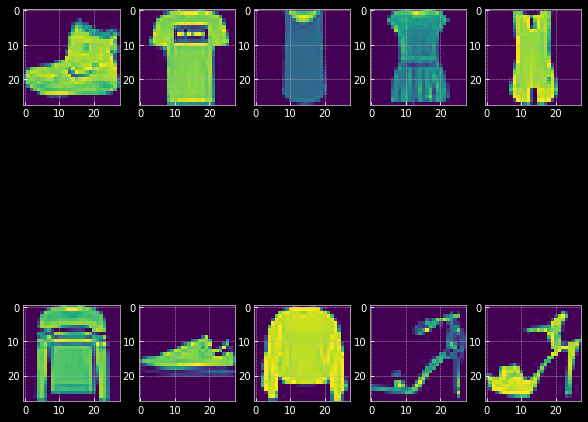

In [47]:
# show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)    
    plt.imshow(image.squeeze().numpy())

# Create the model classes

In [48]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(   # Squential module used to group transformations
            nn.Linear(input_size, n_hidden), # define the transformation per Image
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
        )

    def forward(self, x): #input tensor has dimensions (batch size , no _ channels , img height , img width)
        x = x.view(-1, self.input_size) # reshape the tensor into batch of vector images
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5) #No of output channels = no of kernel
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5) # remember that convlution is the only transformation that changes the number of channels
        self.fc1 = nn.Linear(n_feature*4*4, 50) # group feature maps into one vector - to calculate these dimensions use the rules below
        self.fc2 = nn.Linear(50, 10) 
        
    def forward(self, x, verbose=False): # batch size * 1 * 28 * 28 
        x = self.conv1(x)   # b * n_features * 24 * 24 
        x = F.relu(x)    # b * n_features * 24 * 24 
        x = F.max_pool2d(x, kernel_size=2)   # b * n_features * 12 * 12 
        x = self.conv2(x)  # b * n_features * 8 * 8     
        x = F.relu(x) # b * n_features * 8 * 8     
        x = F.max_pool2d(x, kernel_size=2) # b * n_features * 4 * 4
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Calculating output tensors size
- output of convlution layer
$$ W_{convlution} = \frac{W_{input} - W_{filter} - 2 * Padding}{Stride} + 1$$


$$ H_{convlution} = \frac{H_{input} - H_{filter} - 2 * Padding}{Stride} + 1$$

                                       output_channels = number of kernels 
- output of pooling layer
$$ W_{pooling} = \frac{W_{input} - W_{filter}}{Stride} + 1 $$


$$ H_{pooling} = \frac{W_{input} - W_{filter}}{Stride} + 1 $$

                                        output_channels = input_channels

### Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### The training and testing function per epoch

In [50]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train() # for example switch off dropout/running mean/variance 
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss instead of Avg                                                            
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [51]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 10):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.291525
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.905931
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.497369
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.086528
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.035294
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.896352
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.682830
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.740348
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.713031
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.610963

Test set: Average loss: 0.7275, Accuracy: 7271/10000 (73%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.774868
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.729897
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.692883
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.519690
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.798219
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.512759
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.483719
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.727599
Train Epoch: 1 [51200/60

# Train a ConvNet with the same number of parameters

In [52]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306609
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.244377
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.692703
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.113643
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.092678
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.731071
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.629106
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.716388
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.628210
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.638037

Test set: Average loss: 0.6780, Accuracy: 7503/10000 (75%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.505529
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.547057
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.685733
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.604286
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.574344
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.740278
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.645271
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.729601
Train Epoch: 1 [51200/60

# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


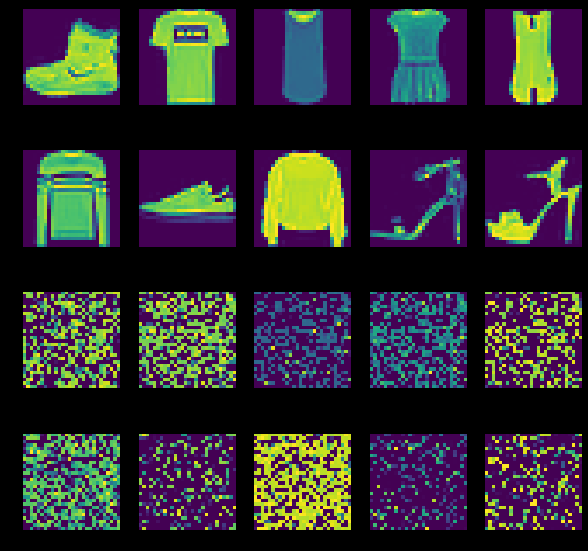

In [54]:
perm = torch.randperm(784)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [55]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309988
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.267984
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.161736
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.820698
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.727453
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.309493
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.072709
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.682157
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.743538
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.690767

Test set: Average loss: 0.7193, Accuracy: 7403/10000 (74%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.640418
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.807933
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.594089
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.854018
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.766247
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.586502
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.431244
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.542766
Train Epoch: 1 [51200/60

# Fully-Connected with Permuted Pixels

In [56]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 10):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.279876
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.926378
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.487133
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.178441
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.936696
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.749420
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.816231
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.596200
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.673831
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.754690

Test set: Average loss: 0.6553, Accuracy: 7569/10000 (76%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.582830
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.474769
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.575031
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.597297
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.459763
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.588903
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.449295
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.647093
Train Epoch: 1 [51200/60

# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [57]:
print (len(accuracy_list))

40


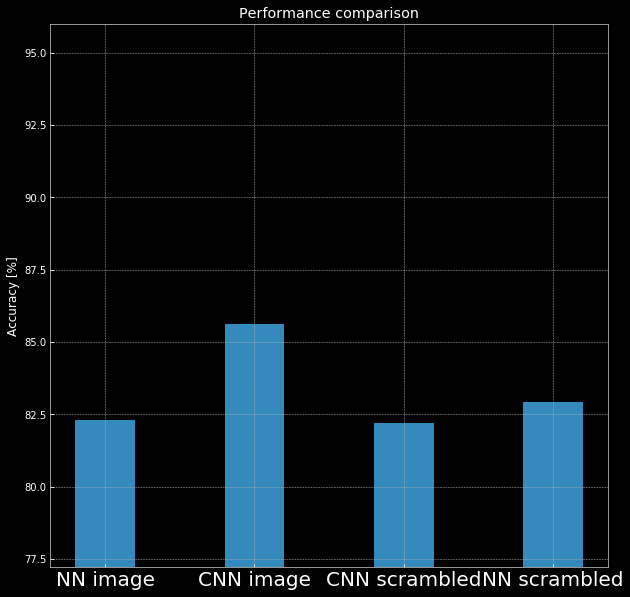

In [61]:
indices = [9,19,29,39]
benchmark_list = list(numpy.array(accuracy_list)[indices])
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        benchmark_list, width=0.4)
plt.ylim((min(benchmark_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [19]:
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backend', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_modules', '_named_members', '_parameters', '_slow_forward', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_

In [20]:
print(dir(model_fnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backend', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_modules', '_named_members', '_parameters', '_slow_forward', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'network', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_par

## Imagenet

Imagenet is the most famous dataset for image classification that is still in use. Real ImageNet dataset is very big (~150Gb). So we will use a smaller version that contains only two classes: bees and ants.

First, download the required files and consturct the dataset.

In [21]:
! rm -rf /tmp/imagenet/unpacked
! mkdir -p /tmp/imagenet/unpacked
! [[ -f /tmp/imagenet/hymenoptera_data.zip ]] || wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O /tmp/imagenet/hymenoptera_data.zip
! cd /tmp/imagenet/unpacked && unzip ../hymenoptera_data.zip > /dev/null
imagenet_dataset = datasets.ImageFolder('/tmp/imagenet/unpacked/hymenoptera_data/val')

--2019-04-20 09:32:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.58.112, 13.35.58.9, 13.35.58.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.58.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: '/tmp/imagenet/hymenoptera_data.zip'

/tmp/imagenet/hymen 100%[===================>]  45.10M   363KB/s    in 2m 28s  

2019-04-20 09:34:52 (312 KB/s) - '/tmp/imagenet/hymenoptera_data.zip' saved [47286322/47286322]



In [ ]:
print('ImageNet classes:', *imagenet_dataset.classes)
# Show a random image and the corresponding target.
for i in range(3):
  img, target = random.choice(imagenet_dataset)
  print('Label of image: %d (%s). Original size: %s' % (target, imagenet_dataset.classes[target], img.size))
  # Reduce image size by half to fit into the page :)
  display.display(img.resize((img.size[0] // 2, img.size[1] // 2)))

In [ ]:
# This is the default transform used in ImageNet models.
inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For visualization purposes we'll create a separate transform that operates in image space.
inference_transform_show = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

# Reload out dataset with this transform.
trasformed_imagenet_dataset = datasets.ImageFolder(
    '/tmp/imagenet/unpacked/hymenoptera_data/val',
    transform=inference_transform,
)

trasformed_imagenet_loader = torch.utils.data.DataLoader(trasformed_imagenet_dataset, batch_size=16, shuffle=False)

# Load a pretrained model.
imagenet_resnet = torchvision.models.resnet18(pretrained=True)

# # The loaded model is trained to classify image across 1000 classes. We have only two classes so have to take the two correpsonding lines from the softmax.
# ANT_CLASS_ID = 310
# BEE_CLASS_ID = 309
# imagenet_resnet.fc.weight.data = imagenet_resnet.fc.weight.data[[ANT_CLASS_ID, BEE_CLASS_ID]]
# imagenet_resnet.fc.bias.data = imagenet_resnet.fc.bias.data[[ANT_CLASS_ID, BEE_CLASS_ID]]

# Check the model accuracy.
# test(imagenet_resnet.cuda(), trasformed_imagenet_loader)

In [ ]:
for i in range(len(trasformed_imagenet_dataset)):
  img, _ = imagenet_dataset[i]
  tensor, target = trasformed_imagenet_dataset[i]
    
  logits = imagenet_resnet(tensor.unsqueeze(0).cuda()).squeeze(0).cpu()
  _, prediction = logits.max(-1)
  if prediction != target:
    print('Img id=%d. Excpected class %s, but predicted class %s.' % (
        i,
        imagenet_dataset.classes[target],
        imagenet_dataset.classes[prediction]))
    display_thumb(img)
  